In [1]:
#---import libraries relating to data manipulation, visualization---------------------------------------------------
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json

#-------import libraries to evaluate the deep learning model---------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#------ import Deep Learning Libraries-------#

import torch
import torch.nn as nn
import torch.optim as optim
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import pickle


pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

import sys
sys.path.append('../../src')  # Add the 'src' directory to the path

#### Import Data Loading and Processing Functions<
from multimodal.helper_functions import reproducible_comp, get_final_df
from multimodal.model_architecture import MultimodalModel

reproducible_comp()

2023-11-07 14:10:49.713558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 14:10:49.713598: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 14:10:49.713622: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 14:10:49.720364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:10:50.482037: W tensorflow/compiler/

In [2]:
file_path = "../../data/processed_data/force_outer.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_outer, category_force_outer, category_names, df_force_outer = get_final_df(data, is_acc_data=0, is_multilabel=1)

file_path = "../../data/processed_data/acc_outer.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_acc_outer, category_acc_outer, category_names, df_acc_outer = get_final_df(data, is_acc_data=1, is_multilabel=1)

In [3]:
labels_force = category_force_outer.copy()
features_force = features_force_outer.copy()
print("Force Features Shape: ", features_force.shape)
print("Force Labels Shape: ", labels_force.shape)

labels_acc = category_acc_outer.copy()
features_acc = features_acc_outer.copy()
print("Acceleration Features Shape: ", features_acc.shape)
print("Acceleration Labels Shape: ", labels_acc.shape)

Force Features Shape:  (1330, 1)
Force Labels Shape:  (1330, 4)
Acceleration Features Shape:  (1330, 3)
Acceleration Labels Shape:  (1330, 4)


#### For Force

In [4]:
max_length = 150
for i in range (len(features_force)):
    if(len(features_force[i][0]<max_length)):
        features_force[i][0]=np.pad(features_force[i][0], (0,max_length-len(features_force[i][0])), 'constant', constant_values=(0))
feat_force= np.zeros(len(features_force) *max_length).reshape(-1, max_length)
for i in range(len(features_force)):
    feat_force[i]= np.concatenate((features_force[i][0]), axis=None)
    

print("Updated Features Shape: ", feat_force.shape)

Updated Features Shape:  (1330, 150)


#### For Acceleration

In [5]:
max_length = 500

for i in range (len(features_acc)):
    if(len(features_acc[i][0]<max_length)):
        features_acc[i][0]=np.pad(features_acc[i][0], (0,max_length-len(features_acc[i][0])), 'constant', constant_values=(0))
        
    if(len(features_acc[i][1]<max_length)):
        features_acc[i][1]=np.pad(features_acc[i][1], (0,max_length-len(features_acc[i][1])), 'constant', constant_values=(0))
    
    if(len(features_acc[i][2]<max_length)):
        features_acc[i][2]=np.pad(features_acc[i][2], (0,max_length-len(features_acc[i][2])), 'constant', constant_values=(0))

feat_acc = np.zeros(len(features_acc)*3*max_length).reshape(-1, 3*max_length)
for i in range(len(features_acc)):
    feat_acc[i]= np.concatenate((features_acc[i][0],features_acc[i][1], features_acc[i][2]), axis=None)
    

print("Updated Features_acc Shape: ", feat_acc.shape)

Updated Features_acc Shape:  (1330, 1500)


In [6]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/multimodal/best_configs/multimodal_outer_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]
print(best_params)

{'lr': 0.0005452723485761036, 'dropout_prob': 0.42333881966763554, 'force_n_layers': 2, 'force_kernel_size': 3, 'force_stride': 5, 'force_padding': 4, 'force_hidden_channels': 65, 'force_pooling_type': 'max', 'force_use_batch_norm': True, 'acc_n_layers': 4, 'acc_kernel_size': 6, 'acc_stride': 2, 'acc_padding': 5, 'acc_hidden_channels': 33, 'acc_pooling_type': 'max', 'acc_use_batch_norm': False}


In [7]:
X_train_force = feat_force.reshape(-1, 1, feat_force.shape[1])
y_train_force = labels_force.copy()

X_train_acc = feat_acc.reshape(-1, 1, feat_acc.shape[1])
y_train_acc = labels_acc.copy()

print(X_train_force.shape)
print(y_train_force.shape)

print(X_train_acc.shape)
print(y_train_acc.shape)

(1330, 1, 150)
(1330, 4)
(1330, 1, 1500)
(1330, 4)


In [8]:
# Define the start, end, and interval
start = 0.95
end = 0.04
interval = -0.01

validation_sizes = [round(start + i * interval, 2) for i in range(int((end - start) / interval) + 1)]

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

# Convert your data to PyTorch tensors
x_train_force = torch.tensor(X_train_force, dtype=torch.float32)
y_train_force = torch.tensor(y_train_force, dtype=torch.float32)

x_train_acc = torch.tensor(X_train_acc, dtype=torch.float32)
y_train_acc = torch.tensor(y_train_acc, dtype=torch.float32)


input_channels = 1
num_classes = 4
force_n_layers = best_params["force_n_layers"]
force_kernel_size = best_params["force_kernel_size"]
force_stride = best_params["force_stride"]
force_padding = best_params["force_padding"]
force_hidden_channels = best_params["force_hidden_channels"]
force_pooling_type = best_params["force_pooling_type"]
force_use_batch_norm = best_params["force_use_batch_norm"]
acc_n_layers = best_params["acc_n_layers"]
acc_kernel_size = best_params["acc_kernel_size"]
acc_stride = best_params["acc_stride"]
acc_padding = best_params["acc_padding"]
acc_hidden_channels = best_params["acc_hidden_channels"]
acc_pooling_type = best_params["force_stride"]
acc_use_batch_norm = best_params["acc_use_batch_norm"]
dropout_prob = best_params["dropout_prob"]

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lists to store results for different validation sizes
results = []

num_epochs = 50

for validation_size in validation_sizes:
    try:
        print(f"Training Size: {int((1-validation_size) * 100)}%")
        train_losses_fold = []  # Store training losses for this validation size
        valid_losses_fold = []  # Store validation losses for this validation size
        f1_scores = []  # Store F1 scores for this validation size

        # Split the data into training and validation sets for this validation size
        x_train_force_split, x_valid_force_split, y_train_force_split, y_valid_force_split = train_test_split(
            x_train_force, y_train_force, test_size=validation_size, random_state=42
        )
        
        x_train_acc_split, x_valid_acc_split, y_train_acc_split, y_valid_acc_split = train_test_split(
            x_train_acc, y_train_acc, test_size=validation_size, random_state=42
        )

        train_dataset_force = TensorDataset(x_train_force_split, y_train_force_split)
        valid_dataset_force = TensorDataset(x_valid_force_split, y_valid_force_split)

        train_dataset_acc = TensorDataset(x_train_acc_split, y_train_acc_split)
        valid_dataset_acc = TensorDataset(x_valid_acc_split, y_valid_acc_split)

        train_loader_force = DataLoader(train_dataset_force, batch_size=64, shuffle=True)
        valid_loader_force = DataLoader(valid_dataset_force, batch_size=64, shuffle=False)

        train_loader_acc = DataLoader(train_dataset_acc, batch_size=64, shuffle=True)
        valid_loader_acc = DataLoader(valid_dataset_acc, batch_size=64, shuffle=False)

        model = MultimodalModel(input_channels, num_classes, 
                    force_n_layers, force_kernel_size, force_stride, force_padding, force_hidden_channels,
                    force_pooling_type, force_use_batch_norm,
                    acc_n_layers, acc_kernel_size, acc_stride, acc_padding, acc_hidden_channels,
                    acc_pooling_type, acc_use_batch_norm, dropout_prob).to(device)
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for (inputs_acc, labels), (inputs_force, lab) in zip(train_loader_acc, train_loader_force):
                inputs_acc, labels, inputs_force = inputs_acc.to(device), labels.to(device), inputs_force.to(device)

                optimizer.zero_grad()

                # Forward pass through the multimodal model
                outputs = model(inputs_force, inputs_acc)
                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            
            train_losses_fold.append(running_loss / len(train_loader_acc))
            
            # Validation loss calculation (similar to training loop)
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for (inputs_acc_valid, labels_valid), (inputs_force_valid, lab) in zip(valid_loader_acc, valid_loader_force):
                    inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
                    outputs_valid = model(inputs_force_valid, inputs_acc_valid)
                    loss_valid = criterion(outputs_valid, labels_valid.float())
                    valid_loss += loss_valid.item()

            valid_losses_fold.append(valid_loss / len(valid_loader_acc))

            if (epoch + 1) % 10 == 0:
                print(f"Training Size: {int((1-validation_size) * 100)}%, Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader_acc)}, Validation Loss: {valid_loss / len(valid_loader_acc)}")

        # Evaluation on the validation set for this validation size
        model.eval()
        y_true_valid = []
        y_pred_valid = []

        with torch.no_grad():
            for (inputs_acc_valid, labels_valid), (inputs_force_valid, lab) in zip(valid_loader_acc, valid_loader_force):
                inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
                labels_valid = labels_valid.int()
                outputs_valid = model(inputs_force_valid, inputs_acc_valid)
                predicted = (outputs_valid > 0).int()
                y_true_valid.append(labels_valid.cpu().numpy())
                y_pred_valid.append(predicted.cpu().numpy())

        # Convert lists to NumPy arrays for calculations
        y_true_valid = np.array(y_true_valid[0]).reshape(-1, 4)
        y_pred_valid = np.array(y_pred_valid[0]).reshape(-1, 4)

        accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
        f1 = f1_score(y_true_valid, y_pred_valid, average='macro')

        results.append({
            "Training Size": int((1-validation_size) * 100),
            "Multi-label Validation Accuracy": accuracy,
            "F1 Score": f1
        })
        print(f"Accuracy: {accuracy}\nF1-Score: {f1}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


Training Size: 5%
Training Size: 5%, Epoch 10/50, Training Loss: 0.6826556026935577, Validation Loss: 0.681514385342598
Training Size: 5%, Epoch 20/50, Training Loss: 0.647734135389328, Validation Loss: 0.6398823529481887
Training Size: 5%, Epoch 30/50, Training Loss: 0.62183877825737, Validation Loss: 0.6470951646566391
Training Size: 5%, Epoch 40/50, Training Loss: 0.6247777342796326, Validation Loss: 0.6394827693700791
Training Size: 5%, Epoch 50/50, Training Loss: 0.6248385310173035, Validation Loss: 0.6289141237735748
Accuracy: 0.6328125
F1-Score: 0.0
Training Size: 6%
Training Size: 6%, Epoch 10/50, Training Loss: 0.6801969110965729, Validation Loss: 0.6797968357801437
Training Size: 6%, Epoch 20/50, Training Loss: 0.6389382481575012, Validation Loss: 0.6349698662757873
Training Size: 6%, Epoch 30/50, Training Loss: 0.6209160387516022, Validation Loss: 0.6255077421665192
Training Size: 6%, Epoch 40/50, Training Loss: 0.5993707478046417, Validation Loss: 0.5812532901763916
Trainin

In [10]:

# Print the results for different training sizes
for result in results:
    print(f"Training Size: {result['Training Size']}%, "
          f"Multi-label Validation Accuracy: {result['Multi-label Validation Accuracy'] * 100:.2f}%, "
          f"F1 Score: {result['F1 Score']:.2f}")


Training Size: 5%, Multi-label Validation Accuracy: 63.28%, F1 Score: 0.00
Training Size: 6%, Multi-label Validation Accuracy: 66.41%, F1 Score: 0.32
Training Size: 6%, Multi-label Validation Accuracy: 68.36%, F1 Score: 0.44
Training Size: 7%, Multi-label Validation Accuracy: 71.88%, F1 Score: 0.55
Training Size: 8%, Multi-label Validation Accuracy: 69.53%, F1 Score: 0.51
Training Size: 9%, Multi-label Validation Accuracy: 72.27%, F1 Score: 0.68
Training Size: 10%, Multi-label Validation Accuracy: 75.00%, F1 Score: 0.65
Training Size: 12%, Multi-label Validation Accuracy: 73.83%, F1 Score: 0.66
Training Size: 13%, Multi-label Validation Accuracy: 75.78%, F1 Score: 0.67
Training Size: 14%, Multi-label Validation Accuracy: 76.17%, F1 Score: 0.64
Training Size: 15%, Multi-label Validation Accuracy: 76.56%, F1 Score: 0.67
Training Size: 16%, Multi-label Validation Accuracy: 80.47%, F1 Score: 0.72
Training Size: 17%, Multi-label Validation Accuracy: 79.69%, F1 Score: 0.71
Training Size: 18%

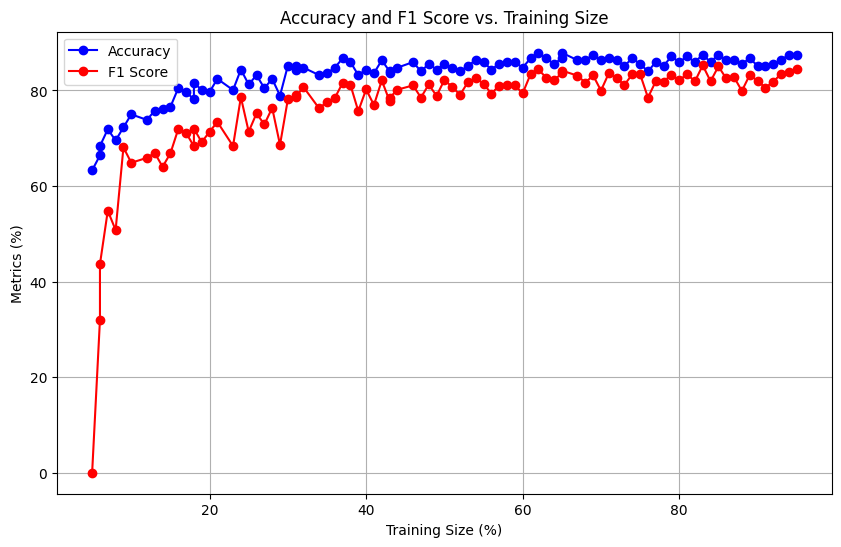

In [11]:
# Extract data for plotting
training_sizes = [result['Training Size'] for result in results]
accuracies = [result['Multi-label Validation Accuracy'] * 100 for result in results]
f1_scores = [result['F1 Score'] *100 for result in results]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, accuracies, label='Accuracy', marker='o', linestyle='-', color='b')
plt.plot(training_sizes, f1_scores, label='F1 Score', marker='o', linestyle='-', color='r')

# Set axis labels and legend
plt.xlabel('Training Size (%)')
plt.ylabel('Metrics (%)')
plt.title('Accuracy and F1 Score vs. Training Size')
plt.legend()

# Show the plot
plt.grid()
plt.show()


# Thank You